# SLT-CE-2: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 (If you cannot access, you can try the same link after configuring your ETH VPN.)

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture05.pdf 

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/lectures/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [114]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42) 

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

# additional imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment

## Texture and corresponding label map
(This texture is used to fit your model.)

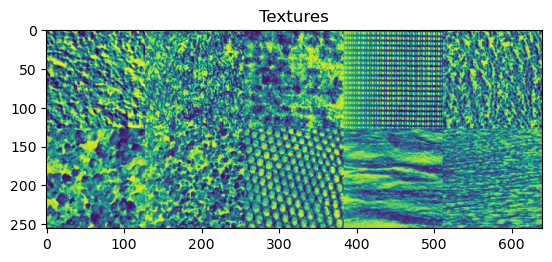

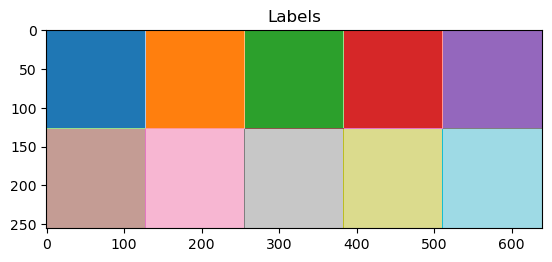

In [3]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

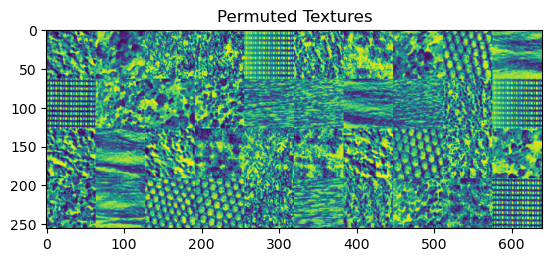

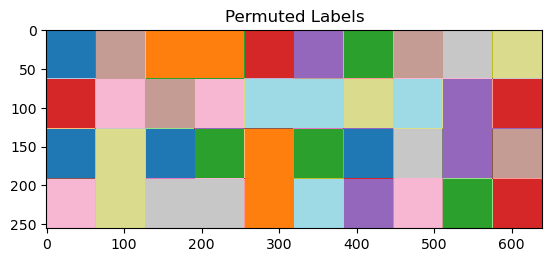

In [4]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.<br>
Hint 2: See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.
</p>

**MAP**: As explained in <a href=http://ieeexplore.ieee.org/document/784981>[1]</a>, 

**Deterministic Annealing**:

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\dots$

In [158]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.centroids = np.zeros((n_clusters, n_bins))
        self.n_iterations = 20
        self.p_c = None
        
    def compute_histograms(self, X, window_size):
        rows, cols = X.shape
        empirical_dist = np.zeros((rows, cols, self.n_bins))
        n_x = np.zeros((rows, cols))
        
        # compute histograms for a window of size window_size around each pixel
        for i in range(rows):
            for j in range(cols):
                window = X[
                    max(0, i - (window_size - 1) // 2):min(rows, i + (window_size - 1) // 2 + 1), 
                    max(0, j - (window_size - 1) // 2):min(cols, j + (window_size - 1) // 2 + 1)
                ]
                n_x[i,j] = window.shape[0] * window.shape[1]
                hist, _ = np.histogram(window, bins=self.n_bins, range=(0, 1)) 
                empirical_dist[i, j, :] = hist / n_x[i, j] # n(x, y) / n(x)
        return empirical_dist, n_x
    
        
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        if self.estimation == "MAP":
            # as in the reference 1, we will use 1/N for p̂(x)
            p_x = 1 / (X.shape[0] * X.shape[1])
            # similarly, we also choose an uniform prior for p(c):
            p_c = 1 / self.n_clusters * np.ones((X.shape[0],X.shape[1],self.n_clusters))
            p_y_given_x, n_x = self.compute_histograms(X, self.window_size)
            
            # initialize p(y|c) as uniform; will be updated in EM like scheme
            p_y_given_c = np.zeros((self.n_clusters, self.n_bins))
            
            n_bins_per_cluster = self.n_bins // self.n_clusters
            
            for cluster in range(self.n_clusters):
                p_y_given_c[cluster, cluster * n_bins_per_cluster:(cluster + 1) * n_bins_per_cluster] = 1.0
                if cluster == self.n_clusters - 1:
                    # fill remaining bins with 1 for the last cluster
                    p_y_given_c[cluster, cluster * n_bins_per_cluster:] = 1.0
                    
                
            
            
                        
            def compute_p_y_given_c(n_x, cluster_assignments, n_clusters, p_y_given_x):
                # p(y|c) i.e. the centroid distributions
                p_y_given_c = np.zeros((n_clusters, self.n_bins))
                
                for c in range(n_clusters):
                    cluster_mask = (cluster_assignments == c)
                    numerator = n_x[cluster_mask] @ p_y_given_x[cluster_mask]
                    denominator = np.sum(n_x[cluster_mask])
                    p_y_given_c[c, :] = numerator / (denominator + 1e-6)
                return p_y_given_c
            
            def update_cluster_assignment(p_y_given_c, p_y_given_x, p_c):
                # update cluster assignments
                nll = -p_y_given_x @ np.log(p_y_given_c.T  + 1e-6) -np.log(p_c + 1e-6)

                cluster_assignments = np.argmin(nll, axis = 2)
                return cluster_assignments
                            
                
            
            
            for _ in range(self.n_iterations):
                cluster_assignments = update_cluster_assignment(p_y_given_c, p_y_given_x, p_c)
                p_y_given_c = compute_p_y_given_c(n_x, cluster_assignments, self.n_clusters, p_y_given_x)


                # TODO: add tolerance
            
            self.centroids = p_y_given_c
            self.p_c = p_c
               
                
            
        elif self.estimation == "DA":
            pass
            
            # Code for Deterministic Annealing estimation
        
        return self
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # uniform prior for centroids
        p_c = 1 / self.n_clusters * np.ones(self.n_clusters)
        # empirical probability distribution:
        p_y_given_x, _ = self.compute_histograms(X, self.window_size)
        
        nll = - p_y_given_x @ np.log(self.centroids.T  + 1e-6) -np.log(p_c[None, None, :] + 1e-6)
        C = np.argmin(nll, axis = 2)
        
        #linear_sum_assignment

        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        return X

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [159]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 14 s, sys: 396 ms, total: 14.4 s
Wall time: 5.32 s


In [170]:
assert HC.centroids.shape == (10, 64)
assert np.allclose(HC.centroids.sum(axis = 1), 1.0, atol = 1e-3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [161]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 4.61 s, sys: 32.1 ms, total: 4.64 s
Wall time: 4.52 s


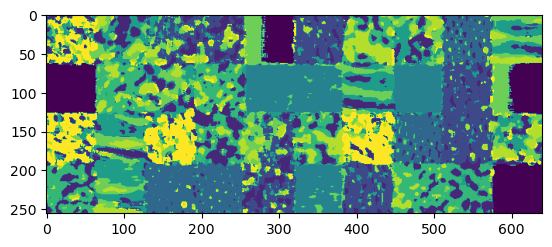

In [162]:
# Plot of predicted label map
plt.imshow(predicted_perm_label_map)

In [163]:
np.unique(predicted_perm_label_map, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([13061, 20486, 22778, 13623, 14345, 16537, 17234, 17665, 13747,
        14364]))

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

In [171]:
def calculate_cm(perm_label_map, predicted_perm_label_map):
    # negative Confusion matrix as cost matrix to minimize
    costs = -confusion_matrix(perm_label_map.flatten(), predicted_perm_label_map.flatten())
    predicted, true = linear_sum_assignment(costs)
    label_dct = {pred: true for pred, true in zip(predicted, true)}
    remapped_pred_perm_label_map = (
        np.array([label_dct[i] for i in predicted_perm_label_map.flatten()])
    )
    cm = confusion_matrix(perm_label_map.flatten(), remapped_pred_perm_label_map)
    return cm

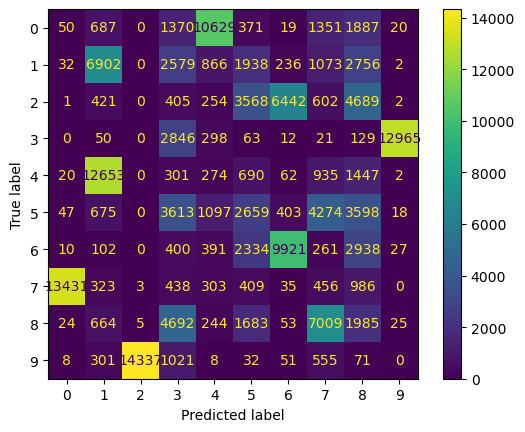

In [172]:
cm = calculate_cm(perm_label_map, predicted_perm_label_map)
ConfusionMatrixDisplay(cm).plot()

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [173]:
def get_accuracy(cm):
    accuracy = np.trace(cm) / np.sum(cm)
    return accuracy

In [175]:
# 3x3 Matrix with accuracy scores of the different parameter combination
n_bins = [16, 32, 64]
window_size = [7, 9, 11]

predicted_perm_label_maps = {}
accuracies = np.zeros((len(n_bins), len(window_size)))
for i, n_bin in enumerate(n_bins):
    for j, w in enumerate(window_size):
        HC = HistogramClustering(n_bins=n_bin, window_size=w)
        HC.fit(texture)
        # get predicted label map
        predicted_perm_label_maps[(n_bin, w)] = HC.predict(perm_texture)
        # calculate confusion matrix
        cm = calculate_cm(perm_label_map, predicted_perm_label_maps[(n_bin, w)])
        # calculate accuracies
        accuracies[i, j] = get_accuracy(cm)

Text(0.5, 1.0, 'Accuracy Scores')

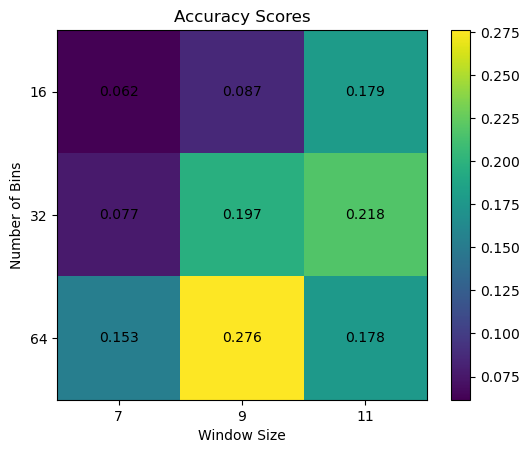

In [199]:
plt.imshow(accuracies, cmap="viridis")
plt.colorbar()

# annotate the accuracy scores
for y in range(len(n_bins)):
    for x in range(len(window_size)):
        plt.text(
            x,
            y, 
            f"{accuracies[y, x]:.3f}", 
            horizontalalignment="center", 
            verticalalignment="center", 
            color="black"
        )

plt.xticks(np.arange(len(window_size)), window_size)
plt.yticks(np.arange(len(n_bins)), n_bins)

plt.xlabel("Window Size")
plt.ylabel("Number of Bins")
plt.title("Accuracy Scores")

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

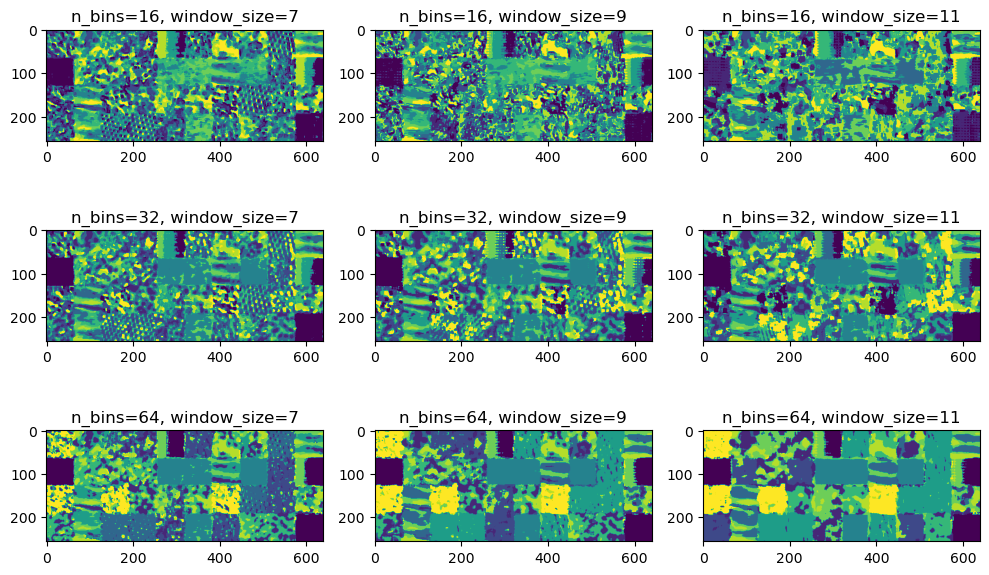

In [207]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i, n_bin in enumerate(n_bins):
    for j, w in enumerate(window_size):
        ax[i, j].imshow(predicted_perm_label_maps[(n_bin, w)])
        ax[i, j].set_title(f"n_bins={n_bin}, window_size={w}")

plt.tight_layout(h_pad = -20)

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [ ]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [ ]:
# Predicted label map for k-means
# Predicted label map for HC

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.